In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [3]:
def component_split(x):
    x_split = str(x).split(",")

    for s in x_split:
        if "comp:" in s.lower():
            return s.strip()
    return None

In [4]:
def label_cleaner(x):
    x_split = str(x).split(",")

    for s in x_split:
        if "comp:" not in s.lower():
            return s.strip()
        
    return None

In [5]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution = 100) -> pd.DataFrame:
    # developers = df["assignees"].value_counts()
    # filtered_developers = developers.index[developers >= minimum_contribution]
    # df = df[df["assignees"].isin(filtered_developers)]

    df["text"] = df.apply(lambda x: str(x["issue_title"]) + "\n" + str(x["issue_body"]), axis=1)
    df = df[df["labels"].notna()]
    df["label"] = df["labels"].apply(label_cleaner)

    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    return df

In [6]:
data_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged.csv"

df = load_dataframe(data_path)
df = prepare_dataframe(df, 40)
df = clean_data(df)

# fig = sns.countplot(x = "assignees", data=df)
# for item in fig.get_xticklabels():
#     item.set_rotation(90)

/tmp/ipykernel_3281412/4140264172.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["labels"].apply(label_cleaner)


In [7]:
len(df)

16342

In [8]:
df = df[df["label"].notna()]
print(len(df))
df.head()

8221


,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,text,label
10,71,11,https://github.com/eclipse-openj9/openj9/issue...,HOWTO Request: Managing changes across depende...,"Like all projects, OpenJ9 builds on the should...",open,mgaudet,<comment><user>pshipton</user><body>Please cle...,NaN,question,HOWTO Request: Managing changes across depende...,question
12,69,13,https://github.com/eclipse-openj9/openj9/issue...,Compilation Output is too Verbose,The output when compiling the OpenJ9 source co...,closed,rservant,<comment><user>rwy7</user><body>When openj9 sw...,NaN,"enhancement, comp:build",Compilation Output is too Verbose\nThe output ...,enhancement
16,65,17,https://github.com/eclipse-openj9/openj9/pull/17,WIP Add support for function pointers in Panama,When invoking a native function (with Panama) ...,closed,tajila,<comment><user>tajila</user><body>Thanks for t...,DanHeidinga,"comp:vm, project:panama",WIP Add support for function pointers in Panam...,project:panama
17,64,18,https://github.com/eclipse-openj9/openj9/pull/18,Disable late attach to self by default,Prevent a JVM from late attaching to itself un...,closed,pdbain-ibm,<comment><user>DanHeidinga</user><body>I haven...,NaN,"jdk9, comp:vm",Disable late attach to self by default\nPreven...,jdk9
18,63,19,https://github.com/eclipse-openj9/openj9/pull/19,Translate TypeNotPresentException to NoClassDe...,"While resolving bootstrap method handles, Type...",closed,babsingh,<comment><user>genie-openj9</user><body>Can on...,NaN,"bug, comp:vm",Translate TypeNotPresentException to NoClassDe...,bug


In [9]:
labels = set()

In [10]:
for val in df["label"].values:
    if val is None:
        continue
    
    split = val.split(",")
    
    for s in split:
        labels.add(s.strip())

In [11]:
labels

{'Epic',
 'JEP',
 'arch:aarch32',
 'arch:aarch64',
 'arch:power',
 'arch:riscv',
 'arch:x86',
 'arch:z',
 'archived',
 'blocker',
 'bug',
 'cmake',
 'criu',
 'dependencies',
 'depends:EclipseCQ',
 'depends:doc',
 'depends:omr',
 'depends:omr:breaking',
 'depends:openjdk',
 'depends:openjdk11',
 'depends:openjdk12',
 'depends:openjdk14',
 'depends:openjdk8',
 'depends:openjdk9',
 'discussion',
 'doc:externals',
 'duplicate',
 'enhancement',
 'footprint',
 'good first issue',
 'help wanted',
 'invalid',
 'jdk-head',
 'jdk10',
 'jdk11',
 'jdk12',
 'jdk13',
 'jdk14',
 'jdk15',
 'jdk16',
 'jdk17',
 'jdk18',
 'jdk19',
 'jdk20',
 'jdk21',
 'jdk22',
 'jdk8',
 'jdk9',
 'os:aix',
 'os:macos',
 'os:windows',
 'os:zos',
 'os:ztpf',
 'perf',
 'perm excluded',
 'prio:high',
 'prio:low',
 'prio:medium',
 'project:MH',
 'project:loom',
 'project:panama',
 'project:valhalla',
 'question',
 'segfault',
 'snapshot',
 'svtRaised',
 'test excluded',
 'test failure',
 'triageRequired',
 'userRaised',
 'wont

<Axes: xlabel='label'>

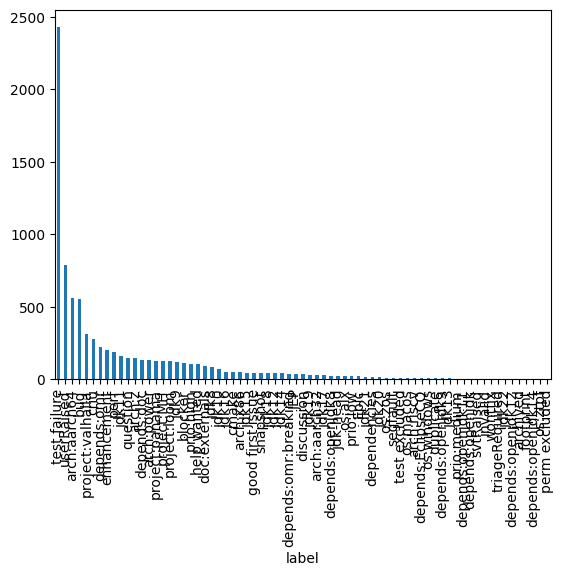

In [12]:
df["label"].value_counts().plot(kind="bar")

In [13]:
label_values = df["label"].value_counts()
filtered_components = label_values.index[label_values >= 40]

filtered_components

Index(['test failure', 'userRaised', 'arch:aarch64', 'bug', 'project:valhalla',
       'criu', 'depends:omr', 'enhancement', 'perf', 'jdk11', 'question',
       'arch:z', 'depends:doc', 'arch:power', 'project:panama', 'project:MH',
       'project:loom', 'jdk9', 'blocker', 'prio:high', 'help wanted',
       'doc:externals', 'jdk8', 'jdk10', 'jdk16', 'cmake', 'arch:x86', 'jdk15',
       'good first issue', 'snapshot', 'jdk18', 'jdk12', 'jdk14',
       'depends:omr:breaking'],
      dtype='object', name='label')

In [14]:
df = df[df["label"].isin(filtered_components)]

In [15]:
len(df)

7774

In [16]:
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=22),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

6219 777 778


/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [17]:
import torch.nn as nn
from transformers import RobertaModel, RobertaTokenizer
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, model_name: str, output_size, embed_size, dropout = 0.1) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
        filter_sizes = [3, 4, 5, 6]
        num_filters = 256
        self._tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.convs1 = nn.ModuleList([nn.Conv2d(4, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, output_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask = attention_mask)[2][-4:]
        x = torch.stack(x, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)  

        return self.relu(logit)
    
    def tokenizer(self) -> RobertaTokenizer:
        return self._tokenizer

In [18]:
label2idx = {label: idx for idx, label in enumerate(list(df["label"].unique()))}

In [19]:
label2idx

{'question': 0,
 'enhancement': 1,
 'project:panama': 2,
 'jdk9': 3,
 'bug': 4,
 'perf': 5,
 'prio:high': 6,
 'jdk8': 7,
 'depends:omr': 8,
 'jdk10': 9,
 'help wanted': 10,
 'good first issue': 11,
 'userRaised': 12,
 'test failure': 13,
 'doc:externals': 14,
 'project:valhalla': 15,
 'jdk11': 16,
 'blocker': 17,
 'jdk12': 18,
 'depends:doc': 19,
 'arch:z': 20,
 'arch:power': 21,
 'arch:aarch64': 22,
 'arch:x86': 23,
 'jdk14': 24,
 'project:MH': 25,
 'jdk15': 26,
 'depends:omr:breaking': 27,
 'cmake': 28,
 'jdk16': 29,
 'snapshot': 30,
 'criu': 31,
 'jdk18': 32,
 'project:loom': 33}

In [20]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, label_column):
        self.tokenizer = tokenizer
        self.labels = [label2idx[label] for label in df[label_column]]
        self.texts = [self.tokenizer(text,
                               padding='max_length', max_length = 500, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [21]:
from torch.optim import Adam
from tqdm import tqdm

In [22]:
train_epoch_loss = []
train_epoch_acc = []
val_epoch_loss = []
val_epoch_acc = []

def train(model, tokenizer, train_data, val_data, learning_rate, epochs, out_file, label_column):
    train, val = Dataset(train_data, tokenizer, label_column=label_column), Dataset(val_data, tokenizer, label_column=label_column)
    batch_size = 20

    train_dataloader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=True
    )
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    best_loss = float("inf")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        print("Using CUDA...")
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        
        train_loss = total_loss_train / len(train_data)
        val_loss = total_loss_val / len(val_data)

        train_acc = total_acc_train / len(train_data)
        val_acc = total_acc_val / len(val_data)

        train_epoch_loss.append(train_loss)
        val_epoch_loss.append(val_loss)
        train_epoch_acc.append(train_acc)
        val_epoch_acc.append(val_acc)

        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}"
        print(log)

        if val_loss < best_loss:
            print("Found new best model. Saving weights...")
            torch.save(model.state_dict(), out_file)
            best_loss = val_loss


In [23]:
EPOCHS = 20
num_classes = len(df["label"].unique())
model = Classifier("roberta-base", num_classes, 768)
tokenizer = model.tokenizer()
LR = 1e-6

train(model, tokenizer, df_train, df_val, LR, EPOCHS, "label_predictor.pt", "label")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using CUDA...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 1 | Train Loss:  0.138                 | Train Accuracy:  0.301                 | Val Loss:  0.124                 | Val Accuracy:  0.353
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 2 | Train Loss:  0.116                 | Train Accuracy:  0.437                 | Val Loss:  0.110                 | Val Accuracy:  0.474
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 3 | Train Loss:  0.108                 | Train Accuracy:  0.475                 | Val Loss:  0.104                 | Val Accuracy:  0.492
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 4 | Train Loss:  0.102                 | Train Accuracy:  0.501                 | Val Loss:  0.100                 | Val Accuracy:  0.515
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 5 | Train Loss:  0.098                 | Train Accuracy:  0.525                 | Val Loss:  0.097                 | Val Accuracy:  0.532
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 6 | Train Loss:  0.094                 | Train Accuracy:  0.545                 | Val Loss:  0.095                 | Val Accuracy:  0.542
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 7 | Train Loss:  0.091                 | Train Accuracy:  0.567                 | Val Loss:  0.092                 | Val Accuracy:  0.561
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 8 | Train Loss:  0.087                 | Train Accuracy:  0.583                 | Val Loss:  0.090                 | Val Accuracy:  0.577
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 9 | Train Loss:  0.084                 | Train Accuracy:  0.600                 | Val Loss:  0.088                 | Val Accuracy:  0.586
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 10 | Train Loss:  0.081                 | Train Accuracy:  0.614                 | Val Loss:  0.087                 | Val Accuracy:  0.579
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 11 | Train Loss:  0.078                 | Train Accuracy:  0.632                 | Val Loss:  0.085                 | Val Accuracy:  0.591
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 12 | Train Loss:  0.076                 | Train Accuracy:  0.643                 | Val Loss:  0.084                 | Val Accuracy:  0.605
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 13 | Train Loss:  0.073                 | Train Accuracy:  0.655                 | Val Loss:  0.082                 | Val Accuracy:  0.607
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 14 | Train Loss:  0.071                 | Train Accuracy:  0.670                 | Val Loss:  0.082                 | Val Accuracy:  0.609
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 15 | Train Loss:  0.069                 | Train Accuracy:  0.678                 | Val Loss:  0.081                 | Val Accuracy:  0.614
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 16 | Train Loss:  0.067                 | Train Accuracy:  0.693                 | Val Loss:  0.080                 | Val Accuracy:  0.619
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 17 | Train Loss:  0.065                 | Train Accuracy:  0.705                 | Val Loss:  0.079                 | Val Accuracy:  0.620
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 18 | Train Loss:  0.062                 | Train Accuracy:  0.714                 | Val Loss:  0.078                 | Val Accuracy:  0.622
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 19 | Train Loss:  0.060                 | Train Accuracy:  0.724                 | Val Loss:  0.077                 | Val Accuracy:  0.629
Found new best model. Saving weights...


100%|██████████| 311/311 [02:22<00:00,  2.19it/s]


Epochs: 20 | Train Loss:  0.058                 | Train Accuracy:  0.736                 | Val Loss:  0.076                 | Val Accuracy:  0.640
Found new best model. Saving weights...


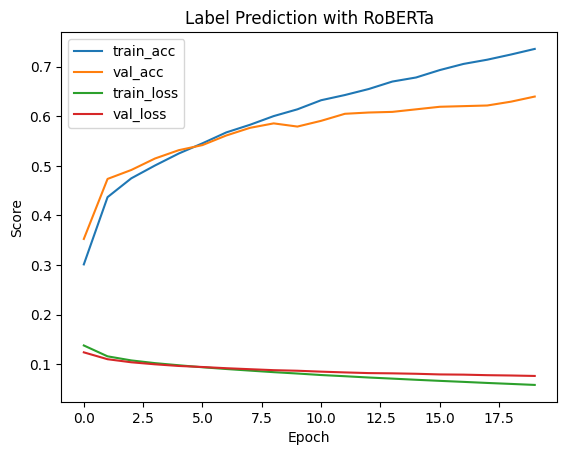

In [52]:
plt.plot(train_epoch_acc, label="train_acc")
plt.plot(val_epoch_acc, label="val_acc")
plt.plot(train_epoch_loss, label="train_loss")
plt.plot(val_epoch_loss, label="val_loss")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Label Prediction with RoBERTa")

plt.show()

In [55]:
import random

idx2label = { idx: label for idx, label in enumerate(label2idx)}

for i in range(5):
    rand = random.randint(0, len(df_test))
    dx = df_test.iloc[rand]

    data = model.tokenizer()(dx["text"])
    ids, mask = data["input_ids"], data["attention_mask"]

    id = torch.tensor([ids]).cuda()
    m = torch.tensor([mask]).cuda()

    g = nn.Softmax(dim=1)

    print(dx["label"], idx2label[int(torch.argmax(g(model(id, m))).cpu().numpy())])

test failure test failure
bug jdk11
criu criu
depends:omr enhancement
userRaised test failure
